<a href="https://colab.research.google.com/github/ZobayerAbedin/DeepLearning/blob/main/characterrecognition_transferlearning_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision.transforms import Compose, Resize, InterpolationMode, ToTensor, Normalize
from torchvision import models
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor

import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image

import os, copy, zipfile, time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Data manupulation

In [53]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [54]:
baseDir = 'C:/Users/SM. Zobayer Abedin/Documents/DeepLearning/street-view-getting-started-with-julia/'
# baseDir = '/kaggle/working/'
# baseDir = '/kaggle/input/street-view-getting-started-with-julia/'

In [55]:
def dataExtraction(extractionDir, filePath):
    # Create the target directory if it does not exist
    if not os.path.exists(extractionDir):
        os.makedirs(extractionDir)

    try:
        with zipfile.ZipFile(filePath, "r") as zfile:
            zfile.extractall(extractionDir)
        print(f"Extraction complete. Files have been extracted to: {extractionDir}")

    except zipfile.BadZipFile:
        print(f"Error: '{filePath}' is not a valid ZIP file or may be corrupted.")

    except FileNotFoundError:
        print(f"Error: The file '{filePath}' does not exist.")

In [56]:
dataExtraction(baseDir, baseDir + 'train.zip')
dataExtraction(baseDir, baseDir + 'test.zip')

Extraction complete. Files have been extracted to: C:/Users/SM. Zobayer Abedin/Documents/DeepLearning/street-view-getting-started-with-julia/
Extraction complete. Files have been extracted to: C:/Users/SM. Zobayer Abedin/Documents/DeepLearning/street-view-getting-started-with-julia/


In [57]:
os.path.isdir(baseDir)

True

In [58]:
class ImageDataset(Dataset):
    def __init__(self, csvFile, imgDir, transform=None):
        self.labels = pd.read_csv(csvFile)
        self.imgDir = imgDir
        self.transform = transform

        self.labels = self.labels.head(200)
        unq = sorted(self.labels['Class'].unique())
        self.toLabel = {char: i for i, char in enumerate(unq)}
        self.labels['Class'] = self.labels['Class'].map(self.toLabel)
        self.labels = self.labels.values.tolist()
        # print(self.labels, type(self.labels))



        # Load all images into memory using parallel processing
        self.images = [None] * len(self.labels)
        with ThreadPoolExecutor() as executor:
            executor.map(self.loadImage, range(len(self.labels)))

    def loadImage(self, idx):
        imgPath = os.path.join(self.imgDir, str(self.labels[idx][0]) + ".Bmp")

        image = Image.open(imgPath).convert("RGB")
        if self.transform:
            image = self.transform(image)
        self.images[idx] = image

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx][1]
        return image, label


In [59]:
imgSize = 32
transform = T.Compose([T.Resize((imgSize, imgSize)),
                       T.ToTensor()
                        ])

# # Load the dataset
# dataset = ImageDataset(baseDir + 'trainLabels.csv', baseDir + 'train', transform)

# # Initialize variables to store the sum and squared sum of pixel values
# # Initialize variables to store the sum and sum of squares of pixel values
# sum_rgb = np.zeros(3)
# sum_sq_rgb = np.zeros(3)
# num_pixels = 0

# # Iterate over each image in the dataset
# for image_tensor, _ in dataset:

#     # Update the sum and sum of squares
#     sum_rgb += image_tensor.sum(dim=(1, 2)).numpy()
#     sum_sq_rgb += (image_tensor ** 2).sum(dim=(1, 2)).numpy()

#     # Update the number of pixels
#     num_pixels += image_tensor.shape[1] * image_tensor.shape[2]

# # Calculate the mean and standard deviation
# mean_rgb = sum_rgb / num_pixels
# std_rgb = np.sqrt(sum_sq_rgb / num_pixels - mean_rgb ** 2)

# print(f'Mean: {mean_rgb}')
# print(f'Std: {std_rgb}')

In [60]:
mean_rgb = [0.51633593, 0.47992162, 0.45069369]
std_rgb = [0.25336818, 0.2420341,  0.25040966]

In [61]:
imgSize = 32
transform = T.Compose([T.Resize((imgSize, imgSize)),
                       T.ToTensor(),
                       T.Normalize(mean_rgb, std_rgb)
                       ])

dataset = ImageDataset(baseDir + 'trainLabels.csv', baseDir + 'train', transform)
torch.save(dataset, baseDir + 'charDatasetTrain.pt')

# torch.serialization.add_safe_globals([ImageDataset, Compose, Resize, ToTensor, Normalize, InterpolationMode])
# dataset = torch.load(baseDir + 'charDatasetTrain.pt')



trainSize = int(0.9 * len(dataset))
testSize = len(dataset) - trainSize
trainData, testData = torch.utils.data.random_split(dataset, [trainSize, testSize], generator=torch.Generator().manual_seed(123))

# Data Augmentation


In [62]:
augTransform = T.Compose([T.ToPILImage(),
                        T.Resize((imgSize, imgSize)),     # Resize the smaller edge to 32
                        T.RandomCrop(32, 4),              # Random crop
                        T.RandomRotation(45),
                        T.ColorJitter(brightness=0.2,     # Randomly change brightness, contrast, saturation, and hue
                                      contrast=0.2,
                                      saturation=0.2,
                                      hue=0.1),
                        T.ToTensor(),                     # Convert to tensor
                        T.RandomErasing(p=0.5, scale=(0.02, 0.5)),
                        T.Normalize(mean_rgb, std_rgb)
                        ])
target = 7 * (10 ** 4)

trainData0 = copy.deepcopy(trainData.dataset)
trainData0.images = []
trainData0.labels = []
target = 500

while(len(trainData0) < target):
    augmented_images = [augTransform(img) for img in trainData.dataset.images]
    trainData0.images.extend(augmented_images)
    trainData0.labels.extend(trainData.dataset.labels)

trainData = torch.utils.data.ConcatDataset([trainData.dataset, trainData0])

torch.save(trainData, baseDir + 'charAugmentedDatasetTrain.pt')

# trainData = torch.load(baseDir + 'charAugmentedDatasetTrain.pt')


batchSize = 32
trainLoader = DataLoader(trainData, batch_size=batchSize, shuffle=True, drop_last=True)
testLoader = DataLoader(testData, batch_size=batchSize, shuffle=False)

In [63]:
print(len(trainData))

800


In [64]:
def deNormalize(image, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return image * std + mean

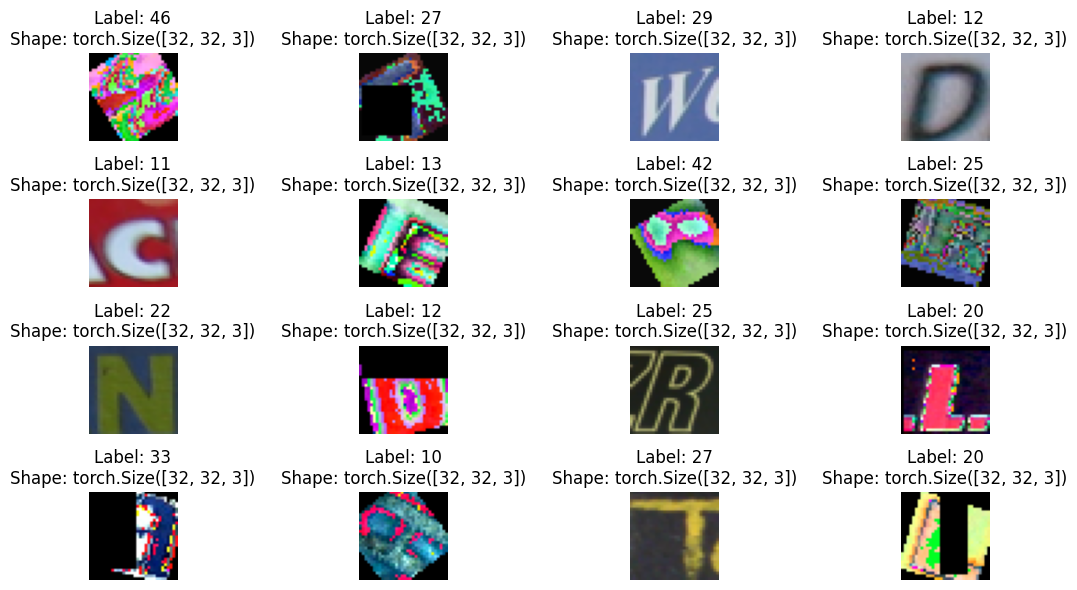

In [65]:
import random

fig, axes = plt.subplots(4, 4, figsize=(12, 6))
axes = axes.flatten()
random.seed(124)
random_indices = random.sample(range(len(trainData)), 16)

for i, index in enumerate(random_indices):
    image, label = trainData[index]
    image = deNormalize(image, mean_rgb, std_rgb)
    image = torch.clamp(image, 0, 1)
    image = image.permute(1, 2, 0)

    axes[i].imshow(image)

    axes[i].set_title(f"Label: {label}\nShape: {image.shape}")
    axes[i].axis("off")


plt.tight_layout()
plt.show()


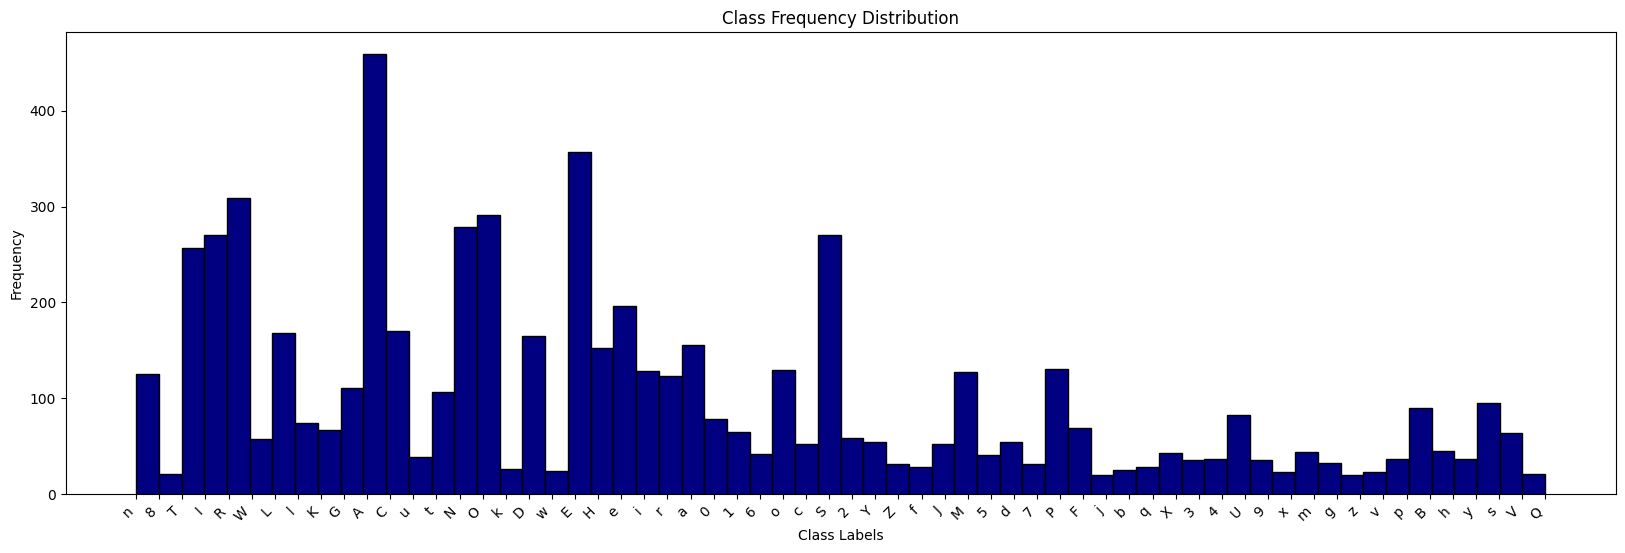

In [66]:
# Load the CSV file
df = pd.read_csv(baseDir + 'trainLabels.csv')
labels = df['Class']


# Plot the frequencies
plt.figure(figsize=(20, 6))
plt.hist(labels, bins = len(set(labels)),color='navy', edgecolor='black')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Class Frequency Distribution')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.show()

# Model

In [78]:
def createNet():

    net = models.resnet152(pretrained=True)

    for param in net.parameters():
        param.requires_grad = False
    in_features = net.fc.in_features
    net.fc = nn.Linear(in_features, 62)
    lossFun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.fc.parameters(), lr=0.001)
    return net, lossFun, optimizer


In [79]:
net, lossFun, optimizer = createNet()
net = net.to(device)
summary(net, (3, 32, 32))

C:\Python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

# Test

In [84]:
def testNet(net, lossFun, optimizer, testLoader):
    net.eval()
    matches = 0
    for data, labels in testLoader:
        # print(labels)
        if device != 'cpu':
            data = data.to(device)
            labels = labels.to(device)
        with torch.no_grad():
            pred = net(data)
        if device != 'cpu':
            labels = labels.to(device)
            pred = pred.to(device)
        pred = torch.argmax(pred, axis=1)
        # print(pred)
        matches += (pred == labels).sum().item()
    # print(matches)
    acc = 100 * matches / len(testLoader.dataset)

    return acc

In [85]:
testNet(net, lossFun, optimizer, testLoader)

tensor([42, 19, 19, 19, 19, 19, 19, 58, 36, 19, 42, 36, 19, 36, 42, 24, 19, 19,
        19, 58])


0.0

# Train

In [86]:
def trainNet(net, lossFun, optimizer, trainLoader):
    epochs = 30

    timeStart = time.process_time()
    timeNow = timeStart

    trainAcc = []
    trainLoss = []
    testAcc = []

    for epoch in range(epochs):

        net.train()

        batchAcc = []
        batchLoss = []

        for data, labels in trainLoader:

            if device != "cpu":
                data = data.to(device)
                labels = labels.to(device)

            ## Calculate forward pass and loss
            pred = net(data)
            loss = lossFun(pred, labels)

            ## backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ## accurecy and loss
            pred = pred.cpu()
            labels = labels.cpu()
            matches = (torch.argmax(pred, axis=1) == labels).float()
            acc = 100 * torch.mean(matches)

            batchAcc.append(acc)
            batchLoss.append(loss.item())
            # print(acc, epoch)

        trainAcc.append(np.mean(batchAcc))
        trainLoss.append(np.mean(batchLoss))

        testAcc.append(testNet(net, lossFun, optimizer, testLoader))

        timeTaken = time.process_time() - timeNow
        elapsedTime = time.process_time() - timeStart
        timeNow = time.process_time()

        print(f"Epoch {epoch+1}/{epochs}, time taken: {timeTaken:.2f}, Lelapsed time: {elapsedTime:.2f} sec, test accuracy {testAcc[-1]:.4f}%")

    return trainAcc, testAcc, trainLoss


# Main


In [87]:
trainAcc, testAcc, trainLoss = trainNet(net, lossFun, optimizer, trainLoader)

tensor([31, 23, 13, 23, 23, 13, 10, 23, 23, 13, 10, 13, 10, 10, 13, 10, 13, 25,
        10, 10])
Epoch 1/30, time taken: 48.45, Lelapsed time: 48.45 sec, test accuracy 20.0000%


KeyboardInterrupt: 

In [ ]:
fig, aa = plt.subplots(1, 2, figsize = (16, 5))

aa[0].plot(trainLoss)
aa[0].set_ylim(0, 100)

aa[1].plot(trainAcc)
aa[1].plot(testAcc)

plt.show()

In [ ]:
torch.save(net.state_dict(), baseDir + 'characterRecognition.pt')

In [ ]:
# net = createNet()[0]
# net.load_state_dict(torch.load(baseDir + 'characterRecognition.pt', map_location=torch.device(device)))

In [ ]:
net.to(device)
acc = testNet(net, lossFun, optimizer, testLoader)
print(f'test accuracy {acc:.4f}%')

In [ ]:
class ImageDatasetTest(Dataset):
    def __init__(self, imgDir, transform=None):
        self.imgDir = imgDir
        self.transform = transform
        # Get a list of all image files in the dir
        self.image_files = sorted(
            [f for f in os.listdir(imgDir) if f.endswith(".Bmp")],
            key=lambda x: int(os.path.splitext(x)[0])
        )
        # print(self.image_files)
        # Load all images into memory using parallel processing
        self.images = [None] * len(self.image_files)
        with ThreadPoolExecutor() as executor:
            executor.map(self.loadImage, range(len(self.image_files)))

    def loadImage(self, idx):
        imgPath = os.path.join(self.imgDir, self.image_files[idx])
        image = Image.open(imgPath).convert("RGB")
        if self.transform:
            image = self.transform(image)
        self.images[idx] = image

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = self.images[idx]
        return image

In [ ]:
datasetTest = ImageDatasetTest(baseDir + 'test', transform)
torch.save(datasetTest, baseDir + 'charDatasetTest.pt')

# torch.serialization.add_safe_globals([ImageDatasetTest])
# datasetTest = torch.load(baseDir + 'charDatasetTest.pt')

testLoader1 = DataLoader(datasetTest, batch_size=1024, shuffle=False)

In [ ]:
datasetTest

In [ ]:
net.eval()
pred = []
with torch.no_grad():
  for x in testLoader1:
    x = x.to(device)
    pred.append(net(x).cpu())
pred1 = pred

In [ ]:
pred = pred1
pred = [torch.argmax(t, axis = 1) for t in pred]
pred = torch.cat(pred)
pred.shape

In [ ]:
alphabet = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
pred = [alphabet[val] for val in pred.tolist()]

In [ ]:
df = pd.DataFrame(pred, columns=['Class'])
df.index = np.arange(6284, len(df) + 6284)
df.index.name = 'ID'
df.head()

In [ ]:
df.to_csv(baseDir + 'submission.csv', index = True)

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(12, 6))
axes = axes.flatten()
random.seed(3423)
random_indices = random.sample(range(len(datasetTest)), 16)

for i, index in enumerate(random_indices):
    image = datasetTest[index]
    label = df.iloc[index, 0]
    image = deNormalize(image, mean_rgb, std_rgb)
    image = torch.clamp(image, 0, 1)
    image = image.permute(1, 2, 0)
    axes[i].imshow(image)

    axes[i].set_title(f"Label: {label}\nShape: {image.shape}")
    axes[i].axis("off")


plt.tight_layout()
plt.show()